In [28]:
import utils
from utils import get_inputs_tags, normalize
import os
import numpy as np
# from sklearn.model_selection import train_test_split
from utils import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from imp import reload 

reload(utils) 

<module 'utils' from '/home/vtsai01/workspace/DLCV_2020FALL/hw1/utils.py'>

In [59]:
img_dir = '/home/vtsai01/workspace/DLCV_2020FALL/hw1/material/p2_data/train/' # 存放图片的文件夹
img_dir_test = '/home/vtsai01/workspace/DLCV_2020FALL/hw1/material/p2_data/test/'

#inputs, tags = utils.get_inputs_tags(img_dir)
train_x, train_y = utils.get_inputs_tags(img_dir)
test_x, test_y = utils.get_inputs_tags(img_dir_test)

num_tags = len(set(tags))   # 120
# train_x, test_x, train_y, test_y = train_test_split(inputs, tags, test_size=0.2, shuffle=None)
#train_x, test_x, train_y, test_y = train_test_split(inputs, tags, test_size=0)

In [60]:
# 测试数据
print(num_tags)
print(inputs.shape)
print(tags.shape)
print(train_x.shape)    
print(train_y.shape)
print(test_x.shape)     
print(test_y.shape) 

40
(40, 56, 46)
(40,)
(360, 56, 46)
(360,)
(40, 56, 46)
(40,)


In [61]:
n_sample, h, w = train_x.shape
X = np.reshape(train_x, [n_sample, -1]) # convert img_mat => img_array
X_ = np.reshape(test_x, [test_x.shape[0], -1])

## 调节PCA压缩维度，观察维度对准确率的影响

In [48]:
n_components = 200 # dimention after pca
component_acc_dict = {}
for cmpnt in range(1, n_components):
    pca = PCA(n_components=cmpnt, svd_solver='randomized', whiten=True, copy=True)
    pca.fit(X)
    X_pca = pca.transform(X)     # 执行pca变换得到的特征 
    X_test_pca = pca.transform(X_)     
    X_pca_norm = normalize(X_pca)     # 归一化
    X_test_pca_norm = normalize(X_test_pca)    # 归一化
    ans = np.matmul(X_pca_norm, X_test_pca_norm.T)    # cosine 相似度
    ans = np.argmax(ans, axis=0)
    pred = []
    for a in ans:
        pred.append(train_y[a])
    acc = np.mean(np.equal(pred, test_y).astype(np.float32))
#     print(acc)
    component_acc_dict[cmpnt] = acc

## 压缩维度和准确率的散点图

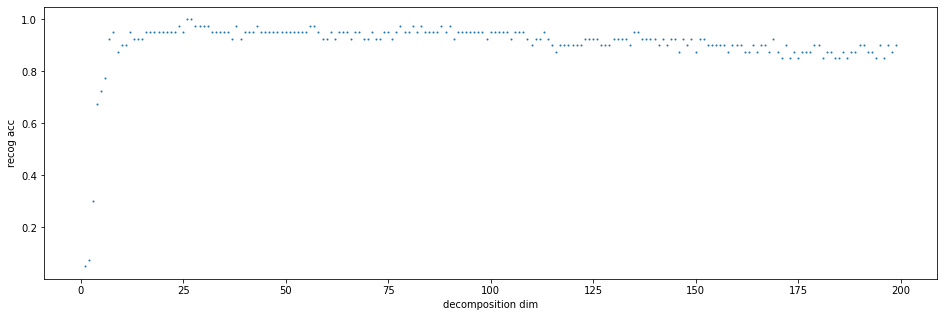

In [49]:
fig, axes = plt.subplots(figsize=(16,5))

axes.set_xlabel('decomposition dim')
axes.set_ylabel('recog acc')
dims = component_acc_dict.keys()
acc = component_acc_dict.values()
axes.scatter(dims, acc,1) # 1代表scatter 点的大小 default=50

## 加入KNN方法，加速运算过程
### 令n_components=256

n: 3
k:1 0.6718097925116088
-
k:3 0.5750014694645271
-
k:5 0.5188679245283019
-
n: 50
k:1 0.9028683947569506
-
k:3 0.8155528125551049
-
k:5 0.7873684829248221
-
n: 170
k:1 0.5405278316581438
-
k:3 0.25321812731440657
-
k:5 0.2032563333921119
-


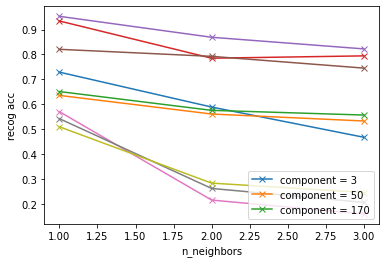

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
n_components = [3, 50, 170]
fig, axes = plt.subplots()
legend = []
for cmpnt in n_components:
    pca = PCA(n_components=cmpnt, svd_solver='randomized', whiten=True, copy=True)
    pca.fit(X)
    X_pca = pca.transform(X)     # 执行pca变换得到的特征 
    X_test_pca = pca.transform(X_)
    n_neighbors=[1, 3, 5]

    nbrs_acc = []
    print("n:", cmpnt)
    for nbr in range(1, len(n_neighbors)+1):
        knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors[nbr-1])
        #knn_clf.fit(X_pca, train_y)
        scores = cross_val_score(knn_clf, X_pca, train_y, cv=3)
        print('k:'+str(n_neighbors[nbr-1]), np.mean(scores))
        print("-")
        #pred = knn_clf.predict(X_test_pca)
        #acc = np.mean(np.equal(pred, test_y).astype(np.float32))
        nbrs_acc.append(scores)

    axes.set_xlabel('n_neighbors')
    axes.set_ylabel('recog acc')
    axes.plot(range(1, len(n_neighbors)+1), nbrs_acc,'x-')
    legend.append('component = ' + str(cmpnt))
axes.legend(legend, loc=4)
# axes.scatter(range(1, n_neighbors+1), nbrs_acc) # 1代表scatter 点的大小 default=50


In [63]:
pca = PCA(n_components=50, svd_solver='randomized', whiten=True, copy=True)
pca.fit(X)
X_pca = pca.transform(X)     # 执行pca变换得到的特征 
X_test_pca = pca.transform(X_)



knn_clf = KNeighborsClassifier(n_neighbors=1)
knn_clf.fit(X_pca, train_y)
#scores = cross_val_score(knn_clf, X_pca, train_y, cv=3, scoring='accuracy')
#print('k:'+str(n_neighbors[nbr-1]), (scores))
print("-")
pred = knn_clf.predict(X_test_pca)
acc = np.mean(np.equal(pred, test_y).astype(np.float32))
print(acc)
nbrs_acc.append(scores)

-
0.875


## 压缩图片重构
### 令n_components = 256做重构

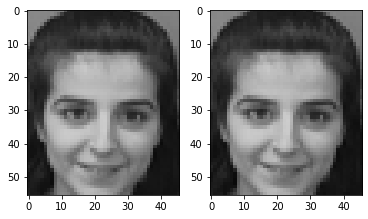

In [26]:
from PIL import Image
import matplotlib.pyplot as plt


n_components = 256
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True, copy=True)
pca.fit(X)
X_pca = pca.transform(X)     # 执行pca变换得到的特征 np.mat(eignmatrix, X)
X_rec = pca.inverse_transform(X_pca)
x_rec = np.reshape(X_rec[1],(56,46))

img_rec = Image.fromarray(x_rec)
img_ori = Image.fromarray(inputs[1])


plt.figure()
plt.subplot(1,2,1)
plt.imshow(img_ori)
plt.subplot(1,2,2)
plt.imshow(img_rec)
plt.show()

### 令n_components = 8做重构

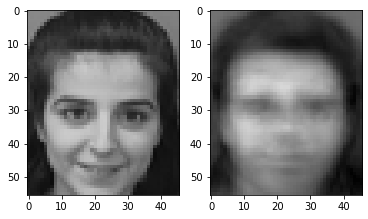

In [27]:
from PIL import Image
n_components = 8
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True, copy=True)
pca.fit(X)                   #PCA 的 copy 务必为True,否则pca.transform(X)中代码中会修改X
X_pca = pca.transform(X)     # 执行pca变换得到的特征 np.mat(eignmatrix, X)
X_rec = pca.inverse_transform(X_pca)
x_rec = np.reshape(X_rec[1],(56,46))

img_rec = Image.fromarray(x_rec)
img_ori = Image.fromarray(inputs[1])


plt.figure()
plt.subplot(1,2,1)
plt.imshow(img_ori)
plt.subplot(1,2,2)
plt.imshow(img_rec)
plt.show()